# **HAVOK study** | forcing features

### **CNN MODELS**

*Ref*: [github@baronefr/rhavok-analysis](github.com/baronefr/rhavok-analysis)

In [1]:
import rhavok
from rhavok.havok import havok
from rhavok.havok import externals

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size'] = 14
from cycler import cycler
import seaborn

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn import metrics

from datetime import datetime

In [2]:
# machine learning environment
try:
    import cayde_env # importing a custom environment for my server
    cayde_env.tensorflow('CPU')
except: print('no need of custom environment')

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten #, Reshape
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

 [ CAYDE computing env ]
[tf] CPU set

In [3]:
# customizations used in this notebook
this_cm = plt.get_cmap('gist_rainbow')

In [4]:
dataset_files = "./data/havok/test_{}.npy"        # [t, v, x]
cnn_mod_files = "./data/havok/models/cnn_{}.h5"   # use timestamp
cnn_res_files = "./data/havok/models/cnn_{}_{}.png"

In [5]:
rhavok.__version__

'0.1.4'

<br>

#### Data import

We import the test dataset from a previously done HAVOK analysis.

In [6]:
vv = np.load(dataset_files.format('v'))
tt = np.load(dataset_files.format('t'))
xx = np.load(dataset_files.format('x'))

In [7]:
print(vv.shape[1], 'signatures available')

21 signatures available


<br>

#### Visualize the embedded coordinates

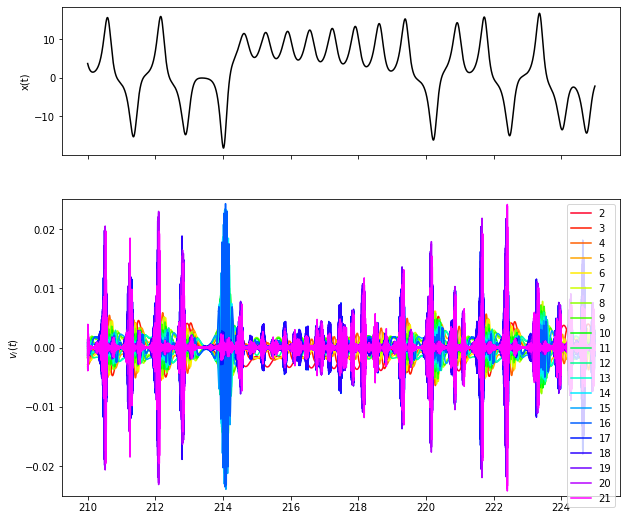

In [8]:
externals.embedded_spectrum(xx, tt, vv, [10000,25000]).show()

<br><br><br>
### Create dataset labels

We wish to isolate the portion of trajectories in which the attractor is going to switch lobe.

In [9]:
# get the index of all sign changes
zero_crosses = np.nonzero(np.diff(xx > 0))[0]

# get the mask of sign changes which have greater stability time
longer = np.append( np.diff(zero_crosses) > 2000, [False])  # these will be class 2

# return only the index values
shorter = np.delete(zero_crosses, longer)
longer = zero_crosses[longer]

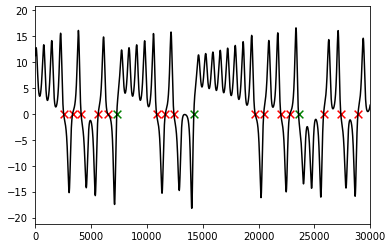

In [10]:
plt.plot(xx, c='k')
plt.scatter(shorter, [0]*len(shorter), marker='x', c='r', s=60)
plt.scatter(longer, [0]*len(longer), marker='x', c='green', s=60)
plt.xlim([0,30000])
plt.show()

In [11]:
selection_window = 700
prediction_margin = 400

In [12]:
candidates = []
for i, diff in enumerate(np.diff(zero_crosses)):
    if diff > 1500:
        left = zero_crosses[i]
        right = zero_crosses[i+1] - selection_window
        while( (right - left) >= selection_window - prediction_margin ):
            candidates.append(right)
            right -= selection_window - prediction_margin
candidates = np.array(candidates)

In [13]:
# mark the window of signal preceding the sign change

labels = np.zeros(len(xx), dtype=int)
labels[ [np.arange(x-(selection_window - prediction_margin),x) for x in candidates] ] = 1
labels[ [np.arange(x-selection_window,x-prediction_margin) for x in shorter] ] = 2
labels[ [np.arange(x-selection_window,x-prediction_margin) for x in longer] ] = 3

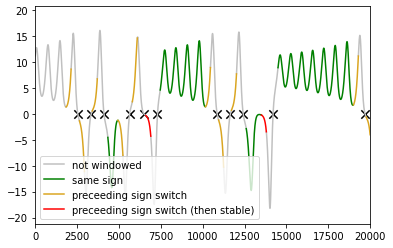

In [14]:
# show me the classes!
rejected = np.ma.masked_where(labels != 0, xx)
normals = np.ma.masked_where(labels != 1, xx)
active1 = np.ma.masked_where(labels != 2, xx)
active2 = np.ma.masked_where(labels != 3, xx)

plt.plot(rejected, lw=1.5, c='silver', label='not windowed')
plt.plot(normals, lw=1.5, c='green', label='same sign')
plt.plot(active1, lw=1.5, c='goldenrod', label='preceeding sign switch')
plt.plot(active2, lw=1.5, c='red', label='preceeding sign switch (then stable)')

plt.scatter(zero_crosses, [0]*len(zero_crosses), marker='x', c = 'k', s=70)
plt.xlim([0,20000])
plt.legend(loc='lower left')
plt.show()

In [15]:
selection_window = selection_window - prediction_margin

In [16]:
slabels = labels - 1
selection = (slabels >= 0)
print(np.sum(selection), 'samples')
print(np.sum(selection)/selection_window, 'windows')

1386300 samples
4621.0 windows


Up to now, `slabels` is a vector which stores:
- 0 for stable areas of the attractor
- 1 for areas preceeding a sign switch which lasts a small amount of time
- 2 for areas preceeding a sign switch which lasts a longer amount of time

In [17]:
selected_ranks = [4, 7, 14, 19]

datax = vv[selection]
datax = datax[:,selected_ranks]
datay = slabels[selection]

In [18]:
#datay[ datay == 2 ] = 1  # remove 3rd class 

In [19]:
print(datax.shape)
print(datay.shape)

(1386300, 4)
(1386300,)


In [20]:
datax[abs(datax) > 1] = 1   # make sure nothing is greater than 1

In [21]:
# normalizing data
normalize_coeff = np.max(datax, axis = 0)
print(normalize_coeff)
datax=datax/normalize_coeff

[0.0037656  0.00758363 0.01124196 0.0314579 ]


In [22]:
N = int(np.sum(selection)/selection_window)
L = selection_window
dim = datax.shape[1]
n_class = len(np.unique(datay))
print(N, L, dim)
print(n_class, 'classes')

4621 300 4
3 classes


In [23]:
dataxseq = []
for i in range(N):
    dataxseq.append(datax[(i*selection_window):((i+1)*selection_window)])

In [24]:
datax = np.array(dataxseq)
datay = datay[::selection_window]
datay_onehot = np.zeros((N,n_class))
for i in range(N):
    datay_onehot[i][datay[i]] = 1.

In [25]:
# last check
print(datax.shape)
print(datay_onehot.shape)

(4621, 300, 4)
(4621, 3)


In [26]:
# define train/test dataset
perc_train = 0.7
N_train = int(perc_train*len(datax))
x_train = datax[:N_train]
y_train = datay_onehot[:N_train]
x_val = datax[N_train:]
y_val = datay_onehot[N_train:]
N_val = len(x_val)

<br><br>

### explore dataset

In [27]:
print(x_train.shape)
print(y_train.shape)

(3234, 300, 4)
(3234, 3)


class: [1. 0. 0.]


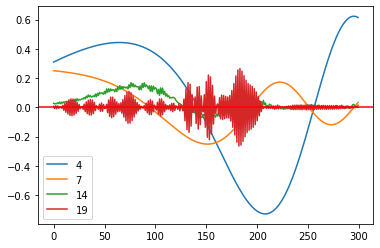

In [28]:
idx = 3

plt.plot(x_train[idx], label = [str(i) for i in selected_ranks])
#plt.xlim([200, 300])
plt.axhline(y=0, color='r', linestyle='-')
plt.legend()
print('class:', y_train[idx])

<br><br>

## extended Havok CNN

In [29]:
input_shape = (L,dim)

import tensorflow.random as tf_r
tf_r.set_seed(220799)

reg = tf.keras.regularizers.l2(0.2)
#reg = regularizers.l1(0.1)
ini = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.05,seed=None)
NCONV = 1
NF = 5

model = Sequential()
if NCONV == 1:
    model.add(Conv1D(filters=NF,
                     kernel_size=10, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(10))
    model.add(Conv1D(filters=5,
                     kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(2,activation='relu'))
    model.add(Dropout(0.05))

model.add(Dense(n_class,activation='softmax')) # softmax!

print('----- Model',NCONV,'-----')
print(model.summary())

# optimizers
# .SGD(lr=0.01,momentum=0.9,nesterov=True) # decay=1e-6
# .RMSprop()
# .Nadam()
opt = tf.keras.optimizers.Adam()

# compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

----- Model 1 -----
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 291, 5)            205       
                                                                 
 average_pooling1d (AverageP  (None, 29, 5)            0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 5)             180       
                                                                 
 flatten (Flatten)           (None, 115)               0         
                                                                 
 dense (Dense)               (None, 2)                 232       
                                                                 
 dropout (Dropout)           (None, 2)                 0         
                                    

2022-06-03 17:54:38.169071: E tensorflow/stream_executor/rocm/rocm_driver.cc:993] could not retrieve ROCM device count: HIP_ERROR_NoDevice
2022-06-03 17:54:38.169536: E tensorflow/stream_executor/rocm/rocm_driver.cc:993] could not retrieve ROCM device count: HIP_ERROR_NoDevice


#### weight plotting

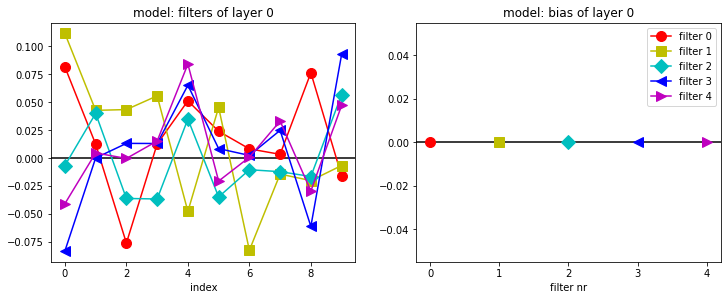

In [30]:
def cnn_weights(model,l=0,label="model"):
    c = ['r','y','c','b','m']
    m = ['o','s','D','<','>']
    ms = 10
    
    w = model.layers[l].get_weights()[0]
    wT = w.T
    M = len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX = plt.subplots(1,2,figsize=(12,4.4))
    ax = AX[0]
    ax.axhline(0,c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax = AX[1]
    ax.axhline(0,c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    return fig
    
cnn_weights(model,0).show()

### Train CNN 

In [31]:
# Hyper-parameters
BATCH_SIZE = 50
EPOCHS = 500

train_acc,val_acc = [],[]
params = [0]  # try various params?
for pp in params:
    print('Model FITTING ...')
    
    fit = model.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    verbose=0,
                    shuffle=True)
    train_acc.append(fit.history['accuracy'][-1])
    val_acc.append(fit.history['val_accuracy'][-1])

    print('> DONE!\n')

Model FITTING ...
> DONE!



In [32]:
# compute a time signature to use for file dumping
dt_string = datetime.now().strftime("%m-%d_%H-%M")

In [33]:
def cnn_history(fit):
    fig,AX = plt.subplots(1,2,figsize=(12,5.))
    ax = AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0,1])
    ax.legend()
    ax = AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0,1.05*np.max(fit.history['loss'])])
    ax.legend()
    return fig

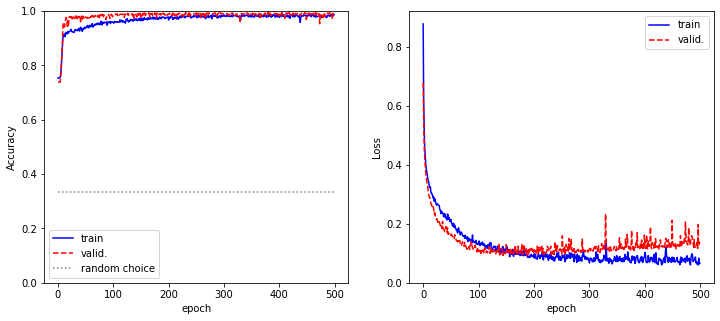

In [34]:
cnn_history(fit).show()

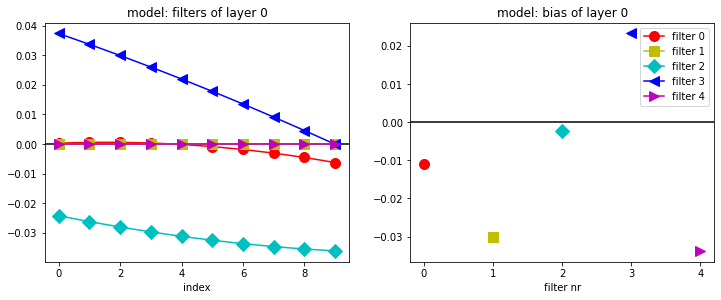

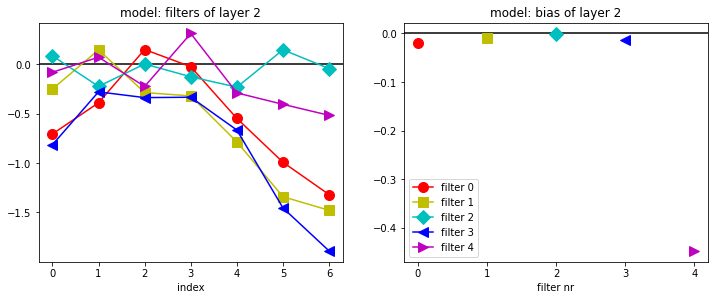

In [35]:
cnn_weights(model,0).savefig(cnn_res_files.format('weight',dt_string))
cnn_weights(model,2).show()

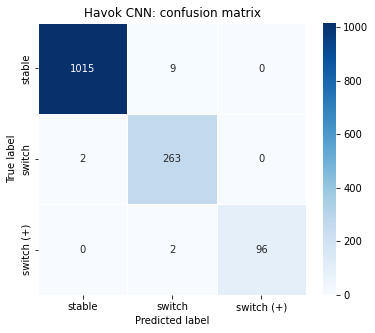

In [36]:
LABELS = ["stable","switch","switch (+)"]

def show_confusion_matrix(validations,predictions,label="Havok CNN",cmap='Blues'):
    matrix = metrics.confusion_matrix(validations,predictions)
    plt.figure(figsize=(6,5))
    seaborn.heatmap(matrix,
                    xticklabels=LABELS,
                    yticklabels=LABELS,
                    annot=True,
                    fmt='d',
                    linecolor='white',
                    linewidths=1,
                    cmap=cmap)
    plt.title(label+': confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

y_pred_val = model.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val,axis=1)
max_y_val = np.argmax(y_val,axis=1)

show_confusion_matrix(max_y_val,max_y_pred_val).savefig( cnn_res_files.format('cm',dt_string) )

In [37]:
model.save( cnn_mod_files.format(dt_string) )
print('saved model with time signature', dt_string)

saved model with time signature 06-03_17-55


<br><br>

## subsampled HAVOK CNN 

### $r=16$

Ok, let's go back to a one-term analysis. How does the CNN perform?

In [129]:
selected_ranks = [15]

datax = vv[selection]
datax = datax[:,selected_ranks]
datay = slabels[selection]

In [130]:
print(datax.shape)
print(datay.shape)

(1386300, 1)
(1386300,)


In [131]:
datax[abs(datax) > 1] = 1   # make sure nothing is greater than 1

In [132]:
# normalizing data
normalize_coeff = np.max(datax, axis = 0)
print(normalize_coeff)
datax=datax/normalize_coeff

[0.02669633]


In [133]:
N = int(np.sum(selection)/selection_window)
L = selection_window
dim = datax.shape[1]
n_class = len(np.unique(datay))
print(N, L, dim)
print(n_class, 'classes')

4621 300 1
3 classes


In [134]:
dataxseq = []
for i in range(N):
    dataxseq.append(datax[(i*selection_window):((i+1)*selection_window)])

In [135]:
datax = np.array(dataxseq)
datay = datay[::selection_window]
datay_onehot = np.zeros((N,n_class))
for i in range(N):
    datay_onehot[i][datay[i]] = 1.

In [136]:
# last check
print(datax.shape)
print(datay_onehot.shape)

(4621, 300, 1)
(4621, 3)


In [137]:
# define train/test dataset
perc_train = 0.7
N_train = int(perc_train*len(datax))
x_train = datax[:N_train]
y_train = datay_onehot[:N_train]
x_val = datax[N_train:]
y_val = datay_onehot[N_train:]
N_val = len(x_val)

#### train again

In [138]:
dim = datax.shape[2]  # new dim here!
input_shape = (L,dim)

import tensorflow.random as tf_r
tf_r.set_seed(220207)

reg = tf.keras.regularizers.l2(0.2)
ini = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.05,seed=None)
NCONV = 1
NF = 5

model = Sequential()
if NCONV == 1:
    model.add(Conv1D(filters=NF,
                     kernel_size=20, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(4))
    model.add(Conv1D(filters=5,
                     kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(2,activation='relu'))
    model.add(Dropout(0.05))

model.add(Dense(n_class,activation='softmax')) # softmax!

print('----- Model',NCONV,'-----')
print(model.summary())
opt = tf.keras.optimizers.Adam()

# compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

----- Model 1 -----
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 281, 5)            105       
                                                                 
 average_pooling1d_7 (Averag  (None, 70, 5)            0         
 ePooling1D)                                                     
                                                                 
 conv1d_17 (Conv1D)          (None, 64, 5)             180       
                                                                 
 flatten_8 (Flatten)         (None, 320)               0         
                                                                 
 dense_16 (Dense)            (None, 2)                 642       
                                                                 
 dropout_8 (Dropout)         (None, 2)                 0         
                                  

In [139]:
# Hyper-parameters
BATCH_SIZE = 40
EPOCHS = 500

train_acc,val_acc = [],[]
params = [0]  # try various params?
for pp in params:
    print('Model FITTING ...')
    
    fit = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    verbose=0,
                    shuffle=True)
    train_acc.append(fit.history['accuracy'][-1])
    val_acc.append(fit.history['val_accuracy'][-1])

    print('> DONE!\n')

Model FITTING ...
> DONE!



In [140]:
# compute a time signature to use for file dumping
#dt_string = datetime.now().strftime("%m-%d_%H-%M") # use same as above

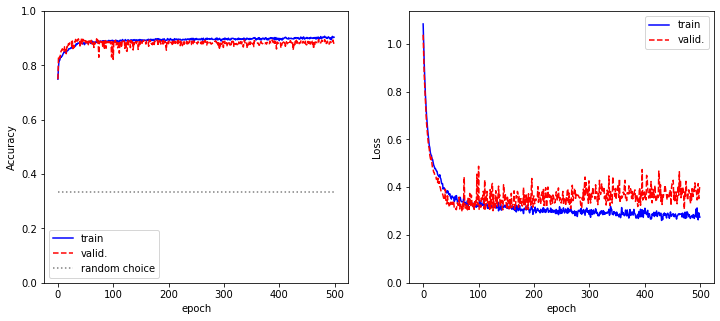

In [141]:
cnn_history(fit).show()

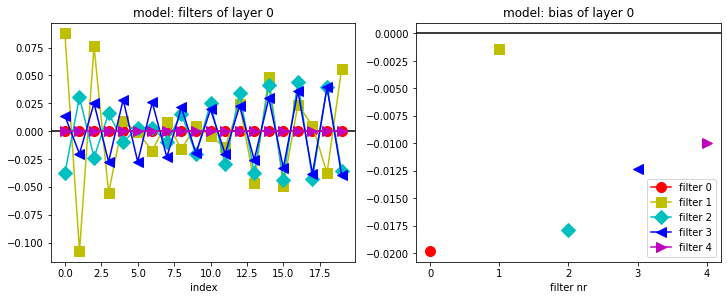

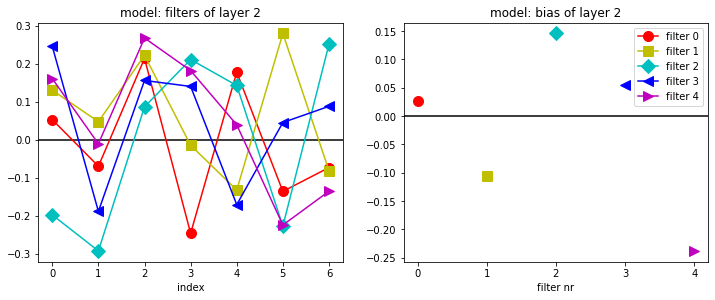

In [142]:
cnn_weights(model,0).savefig(cnn_res_files.format('reduced_weight',dt_string))
cnn_weights(model,2).show()

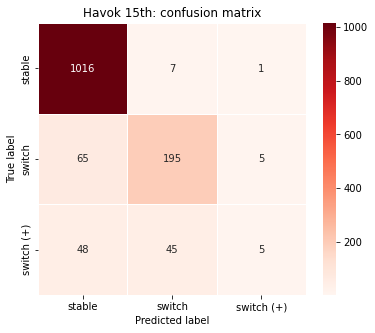

In [143]:
y_pred_val = model.predict(x_val)
max_y_pred_val = np.argmax(y_pred_val,axis=1)
max_y_val = np.argmax(y_val,axis=1)

show_confusion_matrix(max_y_val,max_y_pred_val, label="Havok 15th",
                      cmap = 'Reds').savefig( cnn_res_files.format('reduced_cm', dt_string) )

In [144]:
model.save( cnn_mod_files.format('reduced', dt_string) )
print('saved model with time signature', dt_string)

saved model with time signature 06-03_17-55


<br><br>

### $r=8$

What if we take a lower rank?

In [98]:
selected_ranks = [7]

datax = vv[selection]
datax = datax[:,selected_ranks]
datay = slabels[selection]

In [99]:
print(datax.shape)
print(datay.shape)

(1386300, 1)
(1386300,)


In [100]:
datax[abs(datax) > 1] = 1   # make sure nothing is greater than 1

In [101]:
# normalizing data
normalize_coeff = np.max(datax, axis = 0)
print(normalize_coeff)
datax=datax/normalize_coeff

[0.00758363]


In [102]:
N = int(np.sum(selection)/selection_window)
L = selection_window
dim = datax.shape[1]
n_class = len(np.unique(datay))
print(N, L, dim)
print(n_class, 'classes')

4621 300 1
3 classes


In [103]:
dataxseq = []
for i in range(N):
    dataxseq.append(datax[(i*selection_window):((i+1)*selection_window)])

In [104]:
datax = np.array(dataxseq)
datay = datay[::selection_window]
datay_onehot = np.zeros((N,n_class))
for i in range(N):
    datay_onehot[i][datay[i]] = 1.

In [105]:
# last check
print(datax.shape)
print(datay_onehot.shape)

(4621, 300, 1)
(4621, 3)


In [106]:
# define train/test dataset
perc_train = 0.7
N_train = int(perc_train*len(datax))
x_train = datax[:N_train]
y_train = datay_onehot[:N_train]
x_val = datax[N_train:]
y_val = datay_onehot[N_train:]
N_val = len(x_val)

#### train again

In [107]:
dim = datax.shape[2]  # new dim here!
input_shape = (L,dim)

import tensorflow.random as tf_r
tf_r.set_seed(220207)

reg = tf.keras.regularizers.l2(0.2)
ini = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.05,seed=None)
NCONV = 1
NF = 5

model = Sequential()
if NCONV == 1:
    model.add(Conv1D(filters=NF,
                     kernel_size=20, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(4))
    model.add(Conv1D(filters=5,
                     kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(2,activation='relu'))
    model.add(Dropout(0.05))

model.add(Dense(n_class,activation='softmax')) # softmax!

print('----- Model',NCONV,'-----')
print(model.summary())
opt = tf.keras.optimizers.Adam()

# compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

----- Model 1 -----
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 281, 5)            105       
                                                                 
 average_pooling1d_5 (Averag  (None, 70, 5)            0         
 ePooling1D)                                                     
                                                                 
 conv1d_13 (Conv1D)          (None, 64, 5)             180       
                                                                 
 flatten_6 (Flatten)         (None, 320)               0         
                                                                 
 dense_12 (Dense)            (None, 2)                 642       
                                                                 
 dropout_6 (Dropout)         (None, 2)                 0         
                                  

In [108]:
# Hyper-parameters
BATCH_SIZE = 40
EPOCHS = 500

train_acc,val_acc = [],[]
params = [0]  # try various params?
for pp in params:
    print('Model FITTING ...')
    
    fit = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    verbose=0,
                    shuffle=True)
    train_acc.append(fit.history['accuracy'][-1])
    val_acc.append(fit.history['val_accuracy'][-1])

    print('> DONE!\n')

Model FITTING ...
> DONE!



In [109]:
# compute a time signature to use for file dumping
#dt_string = datetime.now().strftime("%m-%d_%H-%M") # use same as above

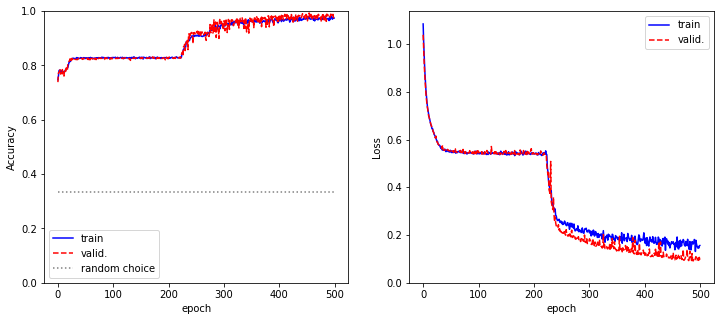

In [110]:
cnn_history(fit).show()

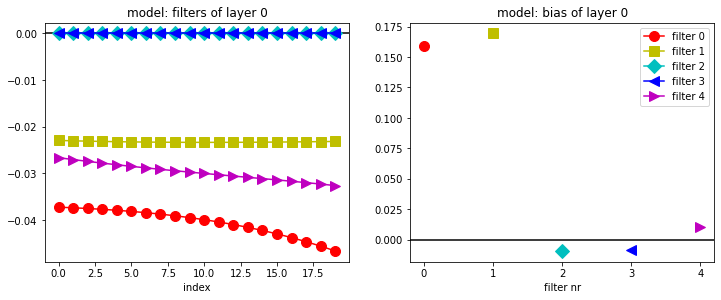

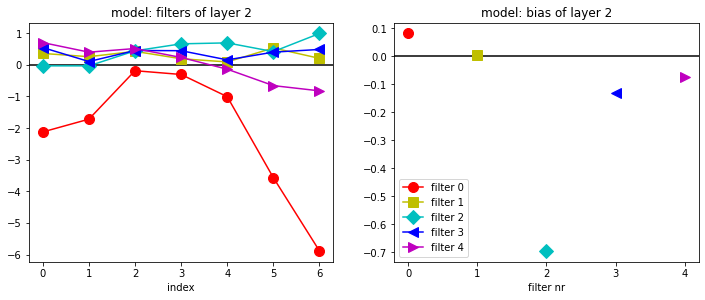

In [111]:
cnn_weights(model,0).show()
cnn_weights(model,2).show()

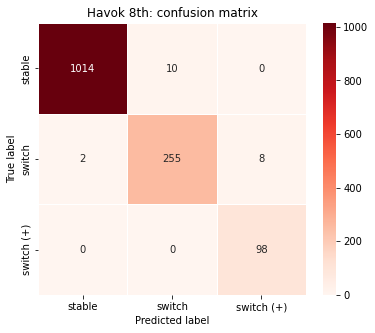

In [112]:
y_pred_val = model.predict(x_val)
max_y_pred_val = np.argmax(y_pred_val,axis=1)
max_y_val = np.argmax(y_val,axis=1)

show_confusion_matrix(max_y_val,max_y_pred_val, label="Havok 8th",
                      cmap = 'Reds').show()

In [113]:
model.save( cnn_mod_files.format('reduced8', dt_string) )
print('saved model with time signature', dt_string)

saved model with time signature 06-03_17-55


***

Code by *Francesco Barone*, last review: 1 Jun 2022. <br>**Workgroup**: Barone Francesco, Nagaro Gianmarco, Ninni Daniele, Valentini Lorenzo.

University of Padua, **Laboratory of Computational Physics**, module B.